<a href="https://colab.research.google.com/github/HikariJadeEmpire/THNumber_img_classification/blob/main/numberclassifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#pip install opencv-python

# Choose one (for Cross Validation)
#pip install pycaret
#pip install tune-sklearn ray[tune]

# STEP 1 : Importing

In [2]:

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Importing OpenCV - the computer vision library
import cv2

# import the modules - Directory management
import glob
import os

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import classification_report 

# STEP 1.1 : SET an important Variables

In [5]:
main_dir = "./Thainumber"

# STEP 2 : Preparing & inspection

Prepare for inspections

In [6]:
file_path_all = list( glob.glob( main_dir + '/**/*.png' ) )

In [7]:
labels = list( map(lambda x: os.path.split( os.path.split(x)[0] )[1] , file_path_all) )

filepath = pd.Series(file_path_all, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

data = pd.concat([filepath, labels], axis=1)

data = data.sample(frac=1).reset_index(drop=True)   # Return a random sample of items from an axis of object.
data

,Filepath,Label
0,./Thainumber\6\IMG_0912.png,6
1,./Thainumber\9\nine4.png,9
2,./Thainumber\6\6-2.png,6
3,./Thainumber\3\3-11.png,3
4,./Thainumber\0\zero3.png,0
...,...,...
295,./Thainumber\6\IMG_0917.png,6
296,./Thainumber\2\2-21.png,2
297,./Thainumber\9\9-40.png,9
298,./Thainumber\6\six2.png,6


In [8]:
data.shape

(300, 2)

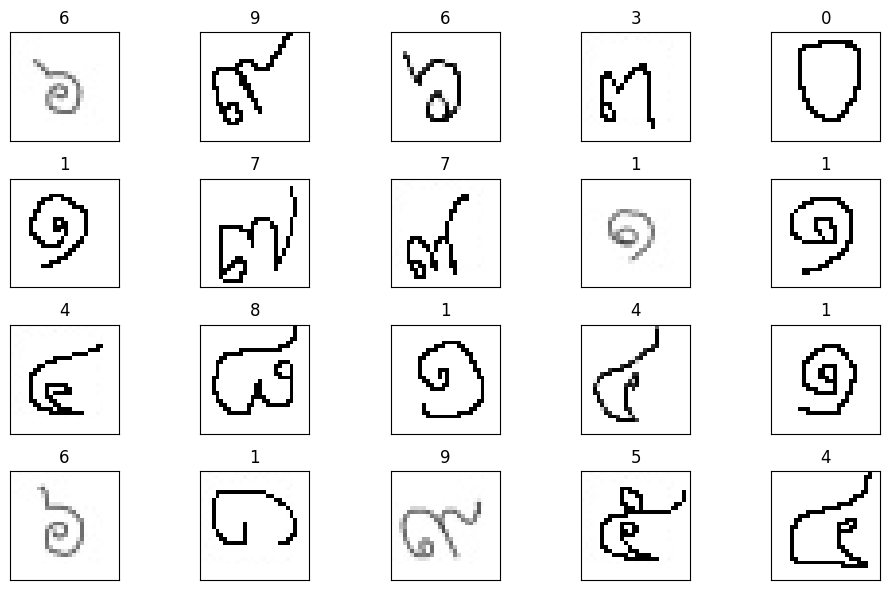

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10,6), subplot_kw = {'xticks':[],'yticks':[]} )

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Counts')

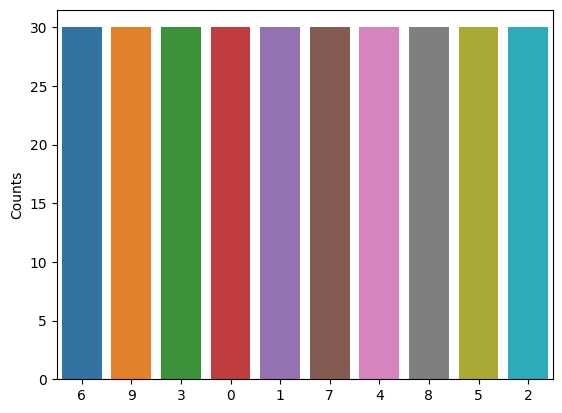

In [10]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.ylabel('Counts')

Prepare for Training

In [11]:
# Prepare X and Y

Before_x = data['Filepath']
y = data['Label']

# To work with X, we need to flatten the images first.
read_x = []

for i in Before_x :
    img_arr = cv2.imread(i)
    img_arr = img_arr.flatten()
    read_x.append(img_arr)

x = np.asarray(read_x)

In [12]:
x = pd.DataFrame(x)
y = pd.DataFrame(y)

In [13]:
df = pd.concat([x,y] , axis=1)
#df.to_csv('image_df.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2343,2344,2345,2346,2347,2348,2349,2350,2351,Label
0,255,255,255,255,255,255,254,254,254,255,...,255,255,255,255,255,255,255,255,255,6
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,9
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,6
3,253,253,253,255,255,255,251,251,251,255,...,255,255,255,255,255,255,255,255,255,3
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0


In [14]:
# Binarize the output

#y = preprocessing.label_binarize( y , classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] )
#print(y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size = 0.30, random_state = 42, stratify = y )

# STEP 3 : Train 

<h4>Cross Validation : AutoML </h4>
By : Pycaret

In [16]:
from pycaret.classification import *

s = setup( df, target = 'Label', session_id = 123, train_size = 0.7  )

,Description,Value
0,Session id,123
1,Target,Label
2,Target type,Multiclass
3,Target mapping,"0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9"
4,Original data shape,"(300, 2353)"
5,Transformed data shape,"(300, 2353)"
6,Transformed train set shape,"(210, 2353)"
7,Transformed test set shape,"(90, 2353)"
8,Numeric features,2352
9,Preprocess,True


In [17]:
best = s.compare_models( sort = 'Accuracy', fold = 5, n_select = 3 )
pull()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,07:50:03
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6143,0.9201,0.6143,0.6449,0.6054,0.5713,0.5767,4.708
rf,Random Forest Classifier,0.6095,0.9091,0.6095,0.6441,0.5936,0.5658,0.5725,2.782
et,Extra Trees Classifier,0.5762,0.9213,0.5762,0.6290,0.5646,0.5293,0.5364,2.898
svm,SVM - Linear Kernel,0.5571,0.0000,0.5571,0.5763,0.5378,0.5077,0.5135,2.682
lightgbm,Light Gradient Boosting Machine,0.5238,0.8646,0.5238,0.5246,0.5053,0.4708,0.4748,3.098
ridge,Ridge Classifier,0.5143,0.0000,0.5143,0.5364,0.5004,0.4603,0.4653,2.606
nb,Naive Bayes,0.4190,0.6770,0.4190,0.4864,0.3996,0.3546,0.3667,3.994
gbc,Gradient Boosting Classifier,0.4190,0.8063,0.4190,0.4445,0.4104,0.3547,0.3600,7.340
lda,Linear Discriminant Analysis,0.3905,0.7563,0.3905,0.4069,0.3689,0.3234,0.3300,2.652
knn,K Neighbors Classifier,0.3333,0.7472,0.3333,0.3534,0.3131,0.2587,0.2655,5.118


In [18]:
display(best)

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=-1, oob_score=False,
                        random_state=123, verbose=0, warm_start=False),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
              

In [19]:
tuned_model = tune_model( best[0], optimize = 'Accuracy', n_iter = 30, fold = 5 )

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,07:55:21
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6905,0.9295,0.6905,0.7222,0.6788,0.6566,0.6633
1,0.5714,0.9227,0.5714,0.6500,0.5884,0.5242,0.5292
2,0.6190,0.9055,0.6190,0.6100,0.5973,0.5760,0.5808
3,0.5952,0.9218,0.5952,0.5954,0.5757,0.5495,0.5530
4,0.6190,0.9231,0.6190,0.6792,0.6047,0.5763,0.5848
Mean,0.6190,0.9205,0.6190,0.6514,0.6090,0.5765,0.5822
Std,0.0398,0.0080,0.0398,0.0461,0.0362,0.0444,0.0453


Fitting 5 folds for each of 30 candidates, totalling 150 fits


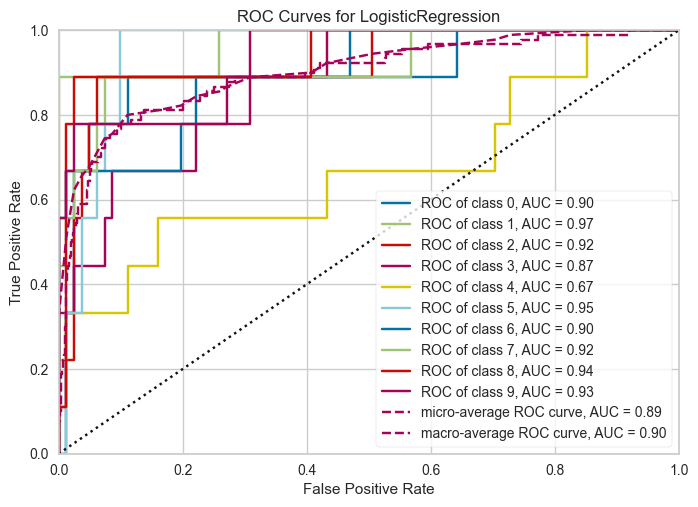

In [20]:
plot_model(tuned_model, plot = 'auc')

<h4>Pipeline</h4>

In [21]:
steps = [
    ('scalar', MinMaxScaler()),
    ('LogisticRegression',LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False))
]

pipeline = Pipeline(steps)

In [22]:
pr = pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))

Training score: 1.0
Pipeline(memory=None,
         steps=[('scalar',
                 MinMaxScaler(clip=False, copy=True, feature_range=(0, 1))),
                ('LogisticRegression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=123,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


# STEP 4 : Test

In [23]:
y_pred = pr.predict(X_test)

print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         9
           1       0.86      0.67      0.75         9
           2       0.70      0.78      0.74         9
           3       0.53      0.89      0.67         9
           4       0.56      0.56      0.56         9
           5       0.86      0.67      0.75         9
           6       0.80      0.89      0.84         9
           7       0.56      0.56      0.56         9
           8       0.70      0.78      0.74         9
           9       0.86      0.67      0.75         9

    accuracy                           0.68        90
   macro avg       0.69      0.68      0.67        90
weighted avg       0.69      0.68      0.67        90



<h4>Evaluations</h4>